In [6]:
import sys
sys.path.append('../')
sys.path.append('../../')

import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from constants import DATASETS, SKEWS, NR_PARTIES, HP_GRID

In [7]:
def get_data_from_json(data_path, experiment_type='clustering', isClustering=True, top=1):
    columns=['dataset', 'skew_type', 'skew', 'nr_clients', 'acc', 'lr',  'mom', 'bs', 'experiment_type']
    df = pd.DataFrame(columns=columns)

    for skew_type in SKEWS.keys():
        for dataset_name in DATASETS:
            # print(f"DATASET: {dataset_name}, SKEW_TYPE: {skew_type}")
            with open(f'{data_path}/{dataset_name}_{skew_type}.json') as f:
                loaded_json = json.load(f)
                for config in loaded_json:
                        global_acc = config['global_lr_mom_bs_acc'][3]
                        derived_hps_acc = [(global_acc - params['diff_acc'], params['lr_mom_bs'], params['closest_lr_mom_bs_acc']) for params in config['derived_params'][:top]]
                        derived_hps_acc = sorted(derived_hps_acc, key= lambda x: x[0], reverse=True)
                        d_acc, derived, closest = derived_hps_acc[0]
                        row = pd.DataFrame([[dataset_name, skew_type, config['skew'], config['nr_clients'], d_acc*100, derived[0], derived[1], derived[2], experiment_type]], columns=columns)
                        if isClustering:
                            row_global = pd.DataFrame([[dataset_name, skew_type, config['skew'], config['nr_clients'], global_acc*100, config['global_lr_mom_bs_acc'][0], config['global_lr_mom_bs_acc'][1], config['global_lr_mom_bs_acc'][2], 'Ground Truth']], columns=columns)
                            df = pd.concat([df, row_global, row])
                        else:
                            df = pd.concat([df, row])
    return df

def plot_barplot(df, hue=[], title='', saveTitle='', saveFig=False, savePath=''):
    sns.set_theme()
    plt.figure(figsize=(15, 5))
    # Set the font size for x tick labels
    plt.rc('xtick', labelsize=30)
    # Set the font size for y tick labels
    plt.rc('ytick', labelsize=30)
    ax = sns.barplot(y="acc", x="dataset", hue="experiment_type",
                hue_order=hue,
                data=df)
    
    sns.set(font_scale=0.8)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 15), textcoords = 'offset points', fontsize='13')
    
    plt.legend(loc='lower left')
    plt.setp(ax.get_legend().get_texts(), fontsize='18')
    
    plt.title(title, fontsize='18')
    plt.ylabel("Validation Accuracy")
    plt.tight_layout()
    ax.tick_params(labelsize=18)
    ax.xaxis.label.set_fontsize(18)
    ax.yaxis.label.set_fontsize(18)
    # ax.set_xticklabels(["MNIST","CIFAR10","SVHN", "EMNIST"])

    if saveFig:
        plt.savefig(fname=f"{savePath}.pdf")
        
    plt.show()

In [11]:
ORIGINAL_FOLDER = "results"
FLORA_FOLDER = f"{ORIGINAL_FOLDER}/flora_extended_data"

df_ext_data = get_data_from_json(f"{ORIGINAL_FOLDER}/extended_data", experiment_type='DBSCAN HPO', top=4, isClustering=True)
df_ext_data['experiment_type'] = df_ext_data['experiment_type'].replace('DBSCAN HPO','DBSCAN')
df_ext_data
df_aplme = get_data_from_json(f'{FLORA_FOLDER}/APLM', experiment_type='APLM', isClustering=False)
df_mplme = get_data_from_json(f'{FLORA_FOLDER}/MPLM', experiment_type='MPLM', isClustering=False)
df_sgme = get_data_from_json(f'{FLORA_FOLDER}/SGM', experiment_type='SGM', isClustering=False)
df_sgm_u_0_1e = get_data_from_json(f'{FLORA_FOLDER}/SGMU', experiment_type='SGM+U', isClustering=False)

hue = ['Ground Truth','DBSCAN', 'SGM', 'SGM+U', 'MPLM', 'APLM']
df = pd.concat([df_ext_data, df_aplme, df_mplme, df_sgme, df_sgm_u_0_1e])
df = df.replace({"mnist": "MNIST", "emnist": "EMNIST", "cifar10": "CIFAR10", "svhn_cropped": "SVHN"})

In [12]:
df_feature = df[df['skew_type'] == 'feature']
df_feature_10 = df_feature[df_feature['nr_clients'] == 10]
df_feature_20 = df_feature[df_feature['nr_clients'] == 20]

df_label = df[df['skew_type'] == 'label']
df_label_10 = df_label[df_label['nr_clients'] == 10]
df_label_20 = df_label[df_label['nr_clients'] == 20]

df_qty = df[df['skew_type'] == 'qty']
df_qty_10 = df_qty[df_qty['nr_clients'] == 10]
df_qty_20 = df_qty[df_qty['nr_clients'] == 20]

df_qty_10_01 = df_qty_10[df_qty_10['skew'] == 0.1]
df_qty_10_04 = df_qty_10[df_qty_10['skew'] == 0.4]
df_qty_10_1 = df_qty_10[df_qty_10['skew'] == 1.0]
df_qty_10_2 = df_qty_10[df_qty_10['skew'] == 2.0]

df_qty_20_01 = df_qty_20[df_qty_20['skew'] == 0.1]
df_qty_20_04 = df_qty_20[df_qty_20['skew'] == 0.4]
df_qty_20_1 = df_qty_20[df_qty_20['skew'] == 1.0]
df_qty_20_2 = df_qty_20[df_qty_20['skew'] == 2.0]

df

,dataset,skew_type,skew,nr_clients,acc,lr,mom,bs,experiment_type
0,MNIST,feature,0.02,10,98.800004,0.5,0.9,8,Ground Truth
0,MNIST,feature,0.02,10,98.450005,0.5,0.6,16,DBSCAN
0,MNIST,feature,0.10,10,98.790000,0.5,0.6,8,Ground Truth
0,MNIST,feature,0.10,10,98.470000,0.5,0.6,16,DBSCAN
0,MNIST,feature,0.02,20,98.750010,0.5,0.9,8,Ground Truth
...,...,...,...,...,...,...,...,...,...
0,EMNIST,qty,2.00,10,84.890350,0.5,0.9,16,SGM+U
0,EMNIST,qty,0.10,20,84.160480,0.5,0.9,16,SGM+U
0,EMNIST,qty,0.40,20,85.152550,0.5,0.9,16,SGM+U
0,EMNIST,qty,1.00,20,85.081196,0.5,0.9,16,SGM+U


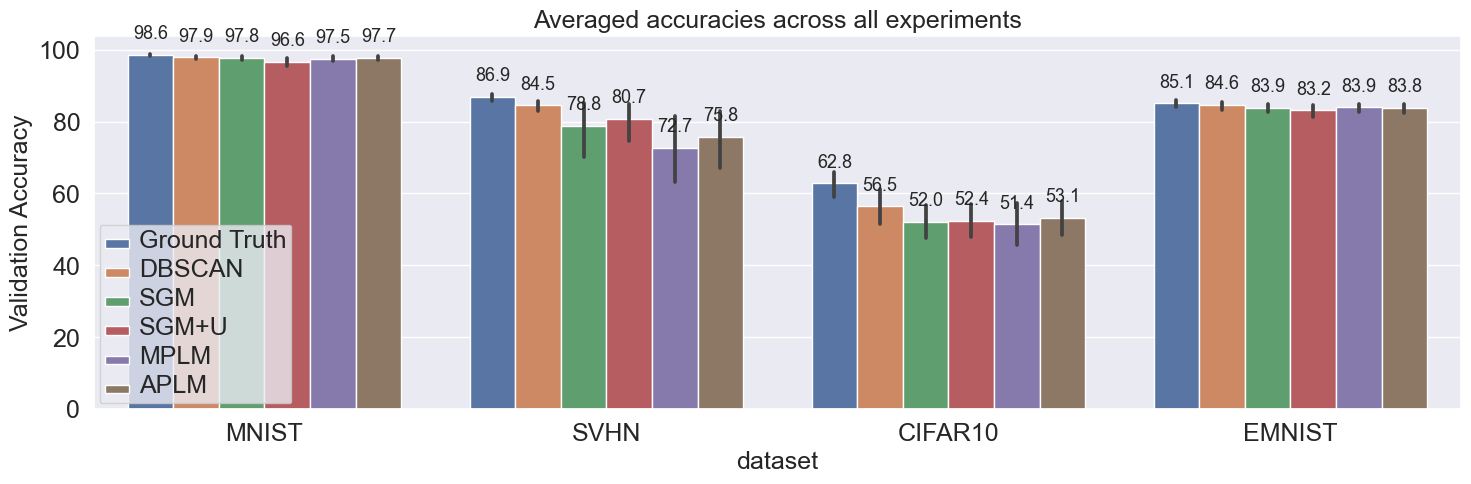

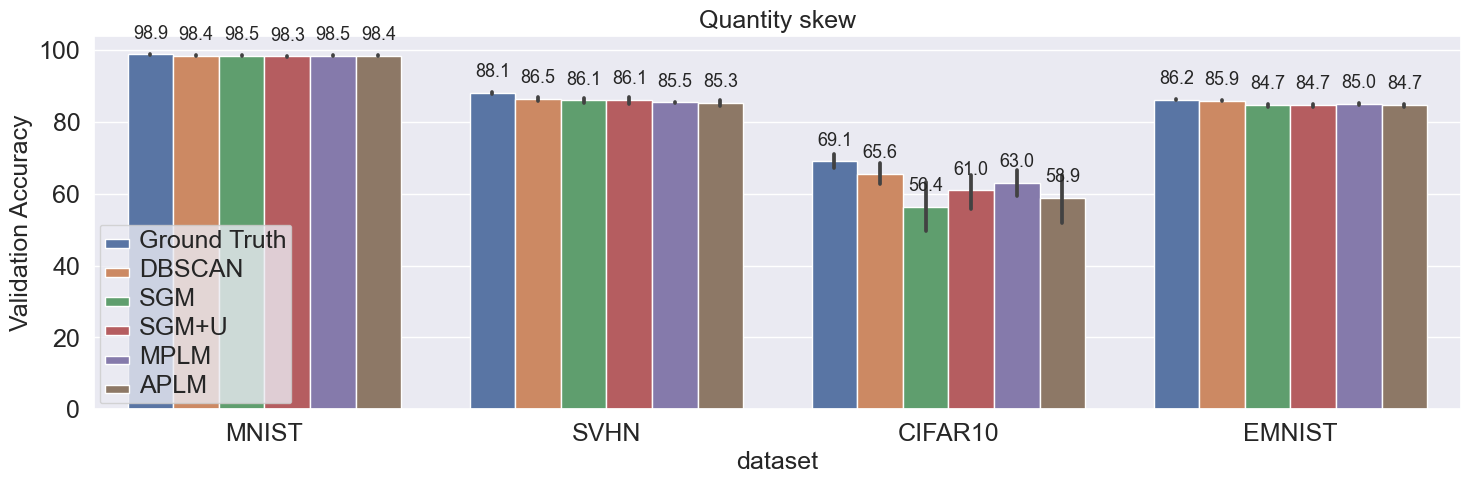

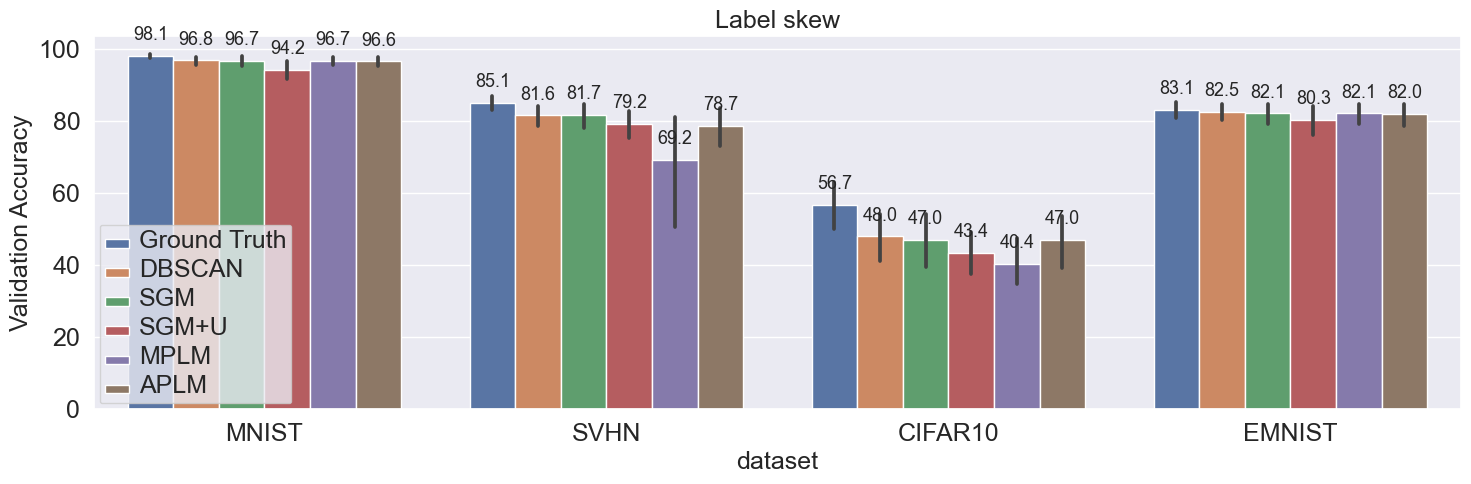

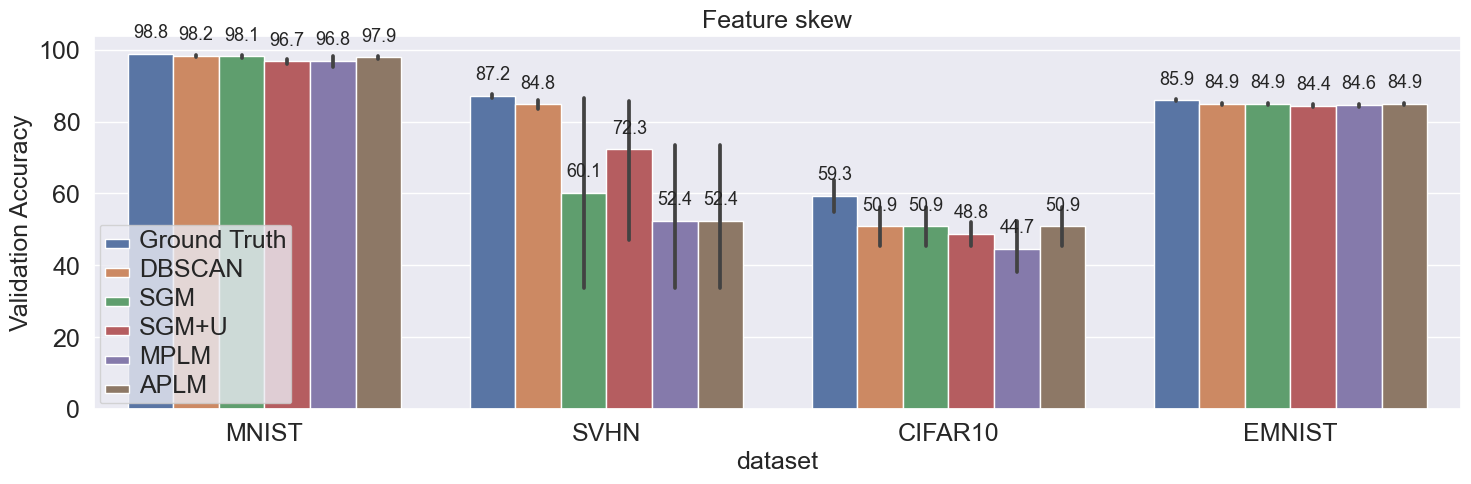

In [13]:
plot_barplot(df, title="Averaged accuracies across all experiments", savePath='results/plots/averaged_across_all_experiments', saveFig=True, hue=hue)

plot_barplot(df_qty, title="Quantity skew", savePath="results/plots/quantity_skew_comparison", saveFig=True, hue=hue)
plot_barplot(df_label, title="Label skew", savePath="results/plots/label_skew_comparison", saveFig=True,  hue=hue)
plot_barplot(df_feature, title="Feature skew", savePath="results/plots/feature_skew_comparison", saveFig=True,hue=hue)


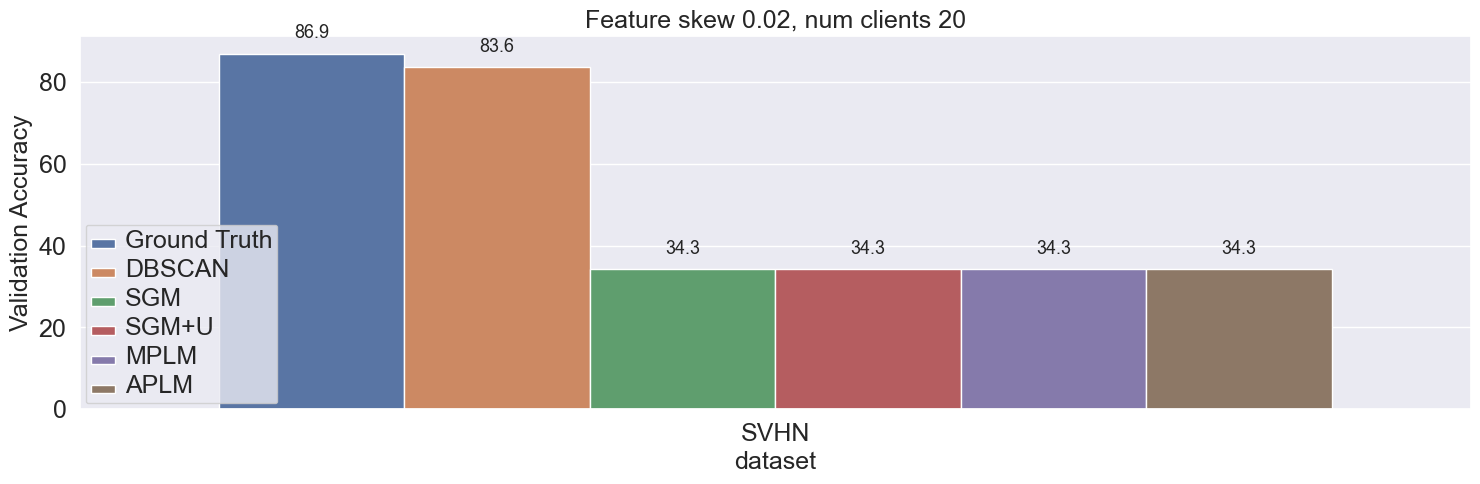

In [15]:
df_f_10 = df_feature[df_feature['nr_clients'] == 10]
df_f_20 = df_feature[df_feature['nr_clients'] == 20]

df_f_20_002 = df_f_20[df_f_20['skew'] == 0.02]
df_f_20_01 = df_f_20[df_f_20['skew'] == 0.1]

df_special2 = df_f_20_002[df_f_20_002['dataset'] == 'SVHN']

plot_barplot(df_special2, title="Feature skew 0.02, num clients 20", saveFig=False, hue=hue)